## 1. 필기 숫자 인식

In [ ]:
import torch
from torch import nn

class LeNet5(nn.Module):
  def __init__(self):
   super(LeNet5, self).__init__() 
   self.conv1 = nn.Conv2d(1, 6, 5) 
   self.relu1 = nn.ReLU() 
   self.pool1 = nn.MaxPool2d(2) 
   self.conv2 = nn.Conv2d(6, 16, 5)    
   self.relu2 = nn.ReLU() 
   self.pool2 = nn.MaxPool2d(2) 
   self.fc1 = nn.Linear(256, 120) 
   self.relu3 = nn.ReLU()
   self.fc2 = nn.Linear(120, 84) 
   self.relu4 = nn.ReLU() 
   self.fc3 = nn.Linear(84, 10) 
   self.relu5 = nn.ReLU()

  def forward(self, input): 
    y = self.conv1(input) 
    y = self.relu1(y) 
    y = self.pool1(y) 
    y = self.conv2(y) 
    y = self.relu2(y) 
    y = self.pool2(y)
    y = y.view(y.shape[0], -1)
    y = self.fc1(y) 
    y = self.relu3(y) 
    y = self.fc2(y) 
    y = self.relu4(y) 
    y = self.fc3(y) 
    y = self.relu5(y) 
    return y 

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import mnist 
from torch.nn import CrossEntropyLoss 
from torch.optim import SGD
from torch.utils.data import DataLoader 
from torchvision.transforms import ToTensor 

class LabelSmoothLoss(nn.Module):
    def __init__(self, smoothing=0.0):
        super(LabelSmoothLoss, self).__init__()
        self.smoothing = smoothing
    
    def forward(self, input, target):
        log_prob = F.log_softmax(input, dim=-1)
        weight = input.new_ones(input.size()) * \
            self.smoothing / (input.size(-1) - 1.)
        weight.scatter_(-1, target.unsqueeze(-1), (1. - self.smoothing))
        loss = (-weight * log_prob).sum(dim=-1).mean()
        return loss

class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                e_w = p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"
                self.state[p]["e_w"] = e_w

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.sub_(self.state[p]["e_w"])  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        p.grad.norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm
        
batch_size = 256

train_dataset = mnist.MNIST(root='./trains', train=True, transform=ToTensor(), download=True) 
test_dataset = mnist.MNIST(root='./test', train=False, transform=ToTensor(),download=True) 
trainloader = DataLoader(train_dataset, batch_size=batch_size)
testloader = DataLoader(test_dataset, batch_size=batch_size)

model = LeNet5().cuda()
base_optimizer = torch.optim.SGD
optimizer = SAM(model.parameters(), base_optimizer, lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()
epochs = 10

In [ ]:
t_accs, v_accs, t_loss, v_loss = [], [], [], []

def disable_running_stats(model):
  def _disable(module):
      if isinstance(module, nn.BatchNorm2d):
          module.backup_momentum = module.momentum
          module.momentum = 0

  model.apply(_disable)

def enable_running_stats(model):
    def _enable(module):
        if isinstance(module, nn.BatchNorm2d) and hasattr(module, "backup_momentum"):
            module.momentum = module.backup_momentum

    model.apply(_enable)

for epoch in range(epochs):
  train_loss = 0
  train_accuracy = 0
  model.train()
  
  # Training pass
  for images, labels in trainloader:
    images = images.cuda() 
    labels = labels.cuda() 
    optimizer.zero_grad()

    enable_running_stats(model)

    output = model(images) 
    ps = torch.exp(output) 
    top_p, top_class = ps.topk(1, dim = 1)
    equals = top_class == labels.view(*top_class.shape) 
    train_accuracy += torch.mean(equals.type(torch.FloatTensor))

    loss = criterion(output, labels)
    loss.backward()

    optimizer.first_step(zero_grad=True)
        
    disable_running_stats(model)
    criterion(model(images),labels).backward()
    optimizer.second_step(zero_grad=True)

    train_loss += loss.item()

  t_accs.append(train_accuracy/len(trainloader)) 
  t_loss.append(train_loss/len(trainloader))

  # Validation pass
  test_loss = 0
  test_accuracy = 0
  # Set the model to evaluation mode
  model.eval()

  for images, labels in testloader:
    images = images.cuda() 
    labels = labels.cuda()
    log_ps = model(images)
    test_loss += criterion(log_ps, labels).item()

    ps = torch.exp(log_ps) 
    top_p, top_class = ps.topk(1, dim = 1)
    equals = top_class == labels.view(*top_class.shape) 
    test_accuracy += torch.mean(equals.type(torch.FloatTensor))

  v_accs.append(test_accuracy/len(testloader)) 
  v_loss.append(test_loss/len(testloader)) 

  print("==> Epoch[{}/{}]".format(epoch+1, epochs))
  print("loss: {:.3f}, Accuracy: {:.3f}, val_loss: {:.3f}, val_accuracy: {:.3f}"
  .format(t_loss[-1], t_accs[-1], v_loss[-1], v_accs[-1]))

==> Epoch[1/10]
loss: 2.305, Accuracy: 0.102, val_loss: 2.302, val_accuracy: 0.102
==> Epoch[2/10]
loss: 2.301, Accuracy: 0.102, val_loss: 2.300, val_accuracy: 0.102
==> Epoch[3/10]
loss: 2.300, Accuracy: 0.105, val_loss: 2.299, val_accuracy: 0.112
==> Epoch[4/10]
loss: 2.298, Accuracy: 0.152, val_loss: 2.297, val_accuracy: 0.177
==> Epoch[5/10]
loss: 2.296, Accuracy: 0.184, val_loss: 2.294, val_accuracy: 0.190
==> Epoch[6/10]
loss: 2.293, Accuracy: 0.189, val_loss: 2.290, val_accuracy: 0.192
==> Epoch[7/10]
loss: 2.287, Accuracy: 0.191, val_loss: 2.281, val_accuracy: 0.193
==> Epoch[8/10]
loss: 2.274, Accuracy: 0.191, val_loss: 2.260, val_accuracy: 0.193
==> Epoch[9/10]
loss: 2.236, Accuracy: 0.221, val_loss: 2.184, val_accuracy: 0.274
==> Epoch[10/10]
loss: 2.058, Accuracy: 0.372, val_loss: 1.838, val_accuracy: 0.450


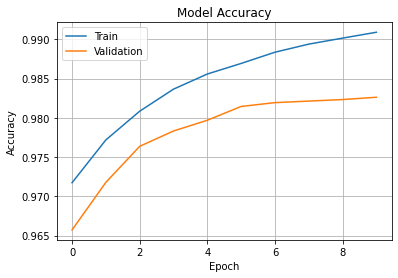

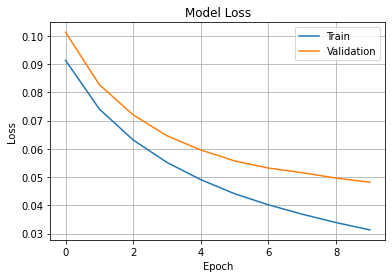

In [ ]:
import matplotlib.pyplot as plt

# 정확률 그래프
plt.title('Model Accuracy')
plt.plot(t_accs, label= "Training Accuracy") 
plt.plot(v_accs, label= "Validation Accuracy") 
plt.ylabel('Accuracy')
plt.xlabel('Epoch') 
plt.legend(['Train','Validation'], loc='best') 
plt.grid()
plt.show()

# 손실 함수 그래프
plt.title('Model Loss')
plt.plot(t_loss, label = "Training loss") 
plt.plot(v_loss, label = "Validation loss") 
plt.ylabel('Loss')
plt.xlabel('Epoch') 
plt.legend(['Train','Validation'], loc='best') 
plt.grid()
plt.show()

## 2. 패션 인식

In [ ]:
from torchvision import datasets, transforms
import torch
from torch import nn, optim
import torch.nn.functional as F

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

# Download and load the training data
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle = False)

In [ ]:
# Define the network architecture
class CNN(nn.Module):
  def __init__(self):
   super(CNN, self).__init__()
   self.body = nn.Sequential(
       nn.Linear(784,256),
       nn.ReLU(),
       nn.Dropout(0.2),
       nn.Linear(256,128),
       nn.ReLU(),
       nn.Dropout(0.2),       
       nn.Linear(128,64),
       nn.ReLU(),
       nn.Dropout(0.2),
       nn.Linear(64,10),
       nn.LogSoftmax(dim=1)     
       )
  def forward(self, x):
    return self.body(x)
   

# Define the model
model = CNN().cuda()

# Define the loss
criterion = nn.NLLLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.002) 
epochs = 10

In [ ]:
t_accs, v_accs, t_loss, v_loss = [], [], [], []

for epoch in range(epochs):
  train_loss = 0
  train_accuracy = 0
  model.train()
  
  # Training pass
  for images, labels in trainloader:
    images = images.cuda()
    images = images.view(images.shape[0], -1)
    labels = labels.cuda() 
    optimizer.zero_grad()

    output = model(images) 
    ps = torch.exp(output) 
    top_p, top_class = ps.topk(1, dim = 1)
    equals = top_class == labels.view(*top_class.shape) 
    train_accuracy += torch.mean(equals.type(torch.FloatTensor))

    loss = criterion(output, labels)
    loss.backward()
    optimizer.step() 
    train_loss += loss.item()

  t_accs.append(train_accuracy/len(trainloader)) 
  t_loss.append(train_loss/len(trainloader))

  # Validation pass
  test_loss = 0
  test_accuracy = 0
  # Set the model to evaluation mode
  model.eval()

  for images, labels in testloader:
    images = images.cuda()
    images = images.view(images.shape[0], -1)
    labels = labels.cuda()
    log_ps = model(images)
    test_loss += criterion(log_ps, labels).item()

    ps = torch.exp(log_ps) 
    top_p, top_class = ps.topk(1, dim = 1)
    equals = top_class == labels.view(*top_class.shape) 
    test_accuracy += torch.mean(equals.type(torch.FloatTensor))

  v_accs.append(test_accuracy/len(testloader)) 
  v_loss.append(test_loss/len(testloader)) 

  print("==> Epoch[{}/{}]".format(epoch+1, epochs))
  print("loss: {:.3f}, Accuracy: {:.3f}, val_loss: {:.3f}, val_accuracy: {:.3f}"
  .format(t_loss[-1], t_accs[-1], v_loss[-1], v_accs[-1]))

==> Epoch[1/30]
loss: 0.326, Accuracy: 0.902, val_loss: 0.130, val_accuracy: 0.961
==> Epoch[2/30]
loss: 0.144, Accuracy: 0.958, val_loss: 0.093, val_accuracy: 0.973
==> Epoch[3/30]
loss: 0.115, Accuracy: 0.967, val_loss: 0.099, val_accuracy: 0.971
==> Epoch[4/30]
loss: 0.101, Accuracy: 0.971, val_loss: 0.076, val_accuracy: 0.978
==> Epoch[5/30]
loss: 0.085, Accuracy: 0.975, val_loss: 0.093, val_accuracy: 0.976
==> Epoch[6/30]
loss: 0.080, Accuracy: 0.976, val_loss: 0.071, val_accuracy: 0.979
==> Epoch[7/30]
loss: 0.073, Accuracy: 0.979, val_loss: 0.083, val_accuracy: 0.977
==> Epoch[8/30]
loss: 0.065, Accuracy: 0.981, val_loss: 0.083, val_accuracy: 0.978
==> Epoch[9/30]
loss: 0.063, Accuracy: 0.982, val_loss: 0.074, val_accuracy: 0.981
==> Epoch[10/30]
loss: 0.058, Accuracy: 0.983, val_loss: 0.082, val_accuracy: 0.979
==> Epoch[11/30]
loss: 0.055, Accuracy: 0.984, val_loss: 0.071, val_accuracy: 0.983
==> Epoch[12/30]
loss: 0.051, Accuracy: 0.985, val_loss: 0.076, val_accuracy: 0.982
=

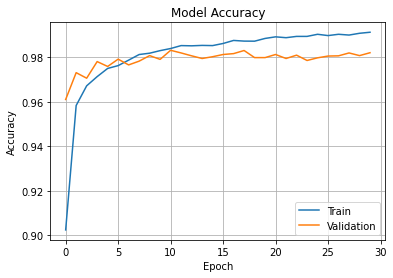

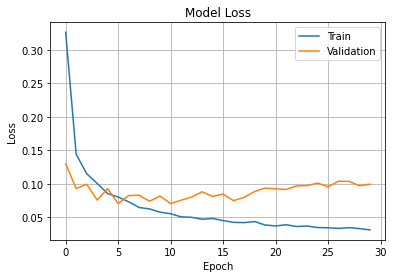

In [ ]:
import matplotlib.pyplot as plt

# 정확률 그래프
plt.title('Model Accuracy')
plt.plot(t_accs, label= "Training Accuracy") 
plt.plot(v_accs, label= "Validation Accuracy") 
plt.ylabel('Accuracy')
plt.xlabel('Epoch') 
plt.legend(['Train','Validation'], loc='best') 
plt.grid()
plt.show()

# 손실 함수 그래프
plt.title('Model Loss')
plt.plot(t_loss, label = "Training loss") 
plt.plot(v_loss, label = "Validation loss") 
plt.ylabel('Loss')
plt.xlabel('Epoch') 
plt.legend(['Train','Validation'], loc='best') 
plt.grid()
plt.show()

## 3. 자연 영상 (CIFAR10) 인식

In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms

# Image Preprocessing
normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]], std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
batch_size = 128
transform = transforms.Compose([transforms.ToTensor(), normalize])
train_dataset = datasets.CIFAR10('root/', train = True, transform = transform, download = True)
test_dataset = datasets.CIFAR10('root/', train = False, transform = transform, download = True)

# Data Loader (Input Pipeline)
trainloader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True, pin_memory=True)
testloader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False, pin_memory=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting root/cifar-10-python.tar.gz to root/
Files already downloaded and verified


In [ ]:
class BasicBlock(nn.Module):
  def __init__(self, in_channels, out_channels, ksize=3, stride=1, pad=1):
    super(BasicBlock, self).__init__()
    self.body = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, ksize, stride, pad),
        nn.ReLU(inplace=True)
    )
  def forward(self, x):
    out = self.body(x)
    return out

# Define the network architecture
class CNN(nn.Module):
  def __init__(self):
   super(CNN, self).__init__()
   self.b1 = BasicBlock(3,32)
   self.b2 = BasicBlock(32,32)
   self.maxpool = nn.MaxPool2d(2,2)
   self.dropout = nn.Dropout(0.25)
   self.b3 = BasicBlock(32,64)
   self.b4 = BasicBlock(64,64)
   self.linear1 = nn.Linear(4096,512)
   self.linear2 = nn.Linear(512,10)

  def forward(self, x):
    out = self.b1(x)
    out = self.b2(out)
    out = self.maxpool(out)
    out = self.dropout(out)
    out = self.b3(out)
    out = self.b4(out)
    out = self.maxpool(out)
    out = self.dropout(out)
    out = out.view(out.size(0),-1)
    out = self.linear1(out)
    out = self.dropout(out)
    out = self.linear2(out)

    return out

# Define the model
model = CNN().cuda()

# Define the loss
criterion = nn.CrossEntropyLoss().cuda()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.002)

epochs = 5

In [ ]:
t_accs, v_accs, t_loss, v_loss = [], [], [], []

for epoch in range(epochs):
  train_loss = 0
  train_accuracy = 0
  model.train()
  
  # Training pass
  for images, labels in trainloader:
    images = images.cuda()
    labels = labels.cuda() 
    optimizer.zero_grad()

    output = model(images) 

    # 로그 확률에 지수 적용
    ps = torch.exp(output) 
    # topk는 k번째로 큰 숫자를 찾아내는 것이다.
    # dim=1 는 dimension을 의미한다.
    top_p, top_class = ps.topk(1, dim = 1)
    # labels를 top_class와 똑같은 형태로 만든다음에, 얼마나 같은게 있는지 확인한다.
    equals = top_class == labels.view(*top_class.shape) 
    # equals를 float으로 바꾸고 평균 정확도를 구한다.
    train_accuracy += torch.mean(equals.type(torch.FloatTensor))

    loss = criterion(output, labels)
    loss.backward()
    optimizer.step() 
    train_loss += loss.item()

  t_accs.append(train_accuracy/len(trainloader)) 
  t_loss.append(train_loss/len(trainloader))

  # Validation pass
  test_loss = 0
  test_accuracy = 0
  # Set the model to evaluation mode
  model.eval()

  for images, labels in testloader:
    images = images.cuda()
    labels = labels.cuda()
    log_ps = model(images)
    test_loss += criterion(log_ps, labels).item()

    ps = torch.exp(log_ps) 
    top_p, top_class = ps.topk(1, dim = 1)
    equals = top_class == labels.view(*top_class.shape) 
    test_accuracy += torch.mean(equals.type(torch.FloatTensor))

  v_accs.append(test_accuracy/len(testloader)) 
  v_loss.append(test_loss/len(testloader)) 

  print("==> Epoch[{}/{}]".format(epoch+1, epochs))
  print("loss: {:.3f}, Accuracy: {:.3f}, val_loss: {:.3f}, val_accuracy: {:.3f}"
  .format(t_loss[-1], t_accs[-1], v_loss[-1], v_accs[-1]))

  model_out_path = './model.pth'
  torch.save(model.state_dict(), model_out_path)

==> Epoch[1/5]
loss: 1.447, Accuracy: 0.475, val_loss: 1.128, val_accuracy: 0.590
==> Epoch[2/5]
loss: 1.075, Accuracy: 0.618, val_loss: 0.915, val_accuracy: 0.672
==> Epoch[3/5]
loss: 0.955, Accuracy: 0.662, val_loss: 0.908, val_accuracy: 0.676
==> Epoch[4/5]
loss: 0.891, Accuracy: 0.685, val_loss: 0.842, val_accuracy: 0.701
==> Epoch[5/5]
loss: 0.850, Accuracy: 0.701, val_loss: 0.834, val_accuracy: 0.709


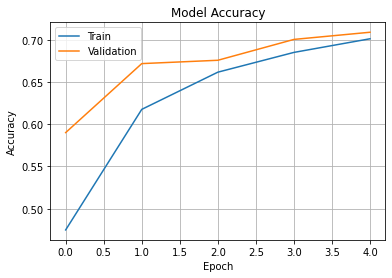

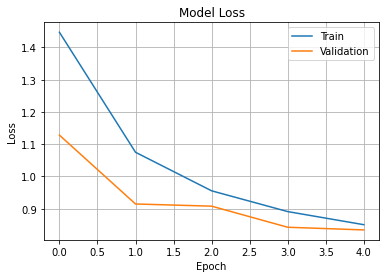

In [ ]:
import matplotlib.pyplot as plt

# 정확률 그래프
plt.title('Model Accuracy')
plt.plot(t_accs, label= "Training Accuracy") 
plt.plot(v_accs, label= "Validation Accuracy") 
plt.ylabel('Accuracy')
plt.xlabel('Epoch') 
plt.legend(['Train','Validation'], loc='best') 
plt.grid()
plt.show()

# 손실 함수 그래프
plt.title('Model Loss')
plt.plot(t_loss, label = "Training loss") 
plt.plot(v_loss, label = "Validation loss") 
plt.ylabel('Loss')
plt.xlabel('Epoch') 
plt.legend(['Train','Validation'], loc='best') 
plt.grid()
plt.show()

## 4. 학습된 모델 저장과 재활용

In [ ]:
import torch

model = CNN().cuda()
model_out_path = './model.pth'
# 저장해둔 모델 파일 불러옴
checkpoint = torch.load(model_out_path)
# nn.Module 내부의 load_state_dict 내장 함수로 모델에 weight load 해줌
model.load_state_dict(checkpoint, strict=True)
print(model)

# Validation pass
test_loss = 0
test_accuracy = 0
# Set the model to evaluation mode
model.eval()

for images, labels in testloader:
  images = images.cuda()
  labels = labels.cuda()
  log_ps = model(images)
  test_loss += criterion(log_ps, labels).item()

  ps = torch.exp(log_ps) 
  top_p, top_class = ps.topk(1, dim = 1)
  equals = top_class == labels.view(*top_class.shape) 
  test_accuracy += torch.mean(equals.type(torch.FloatTensor))

v_accs.append(test_accuracy/len(testloader)) 
v_loss.append(test_loss/len(testloader)) 

print("loss: {:.3f}, Accuracy: {:.3f}, val_loss: {:.3f}, val_accuracy: {:.3f}"
.format(t_loss[-1], t_accs[-1], v_loss[-1], v_accs[-1]))

CNN(
  (b1): BasicBlock(
    (body): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (b2): BasicBlock(
    (body): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (b3): BasicBlock(
    (body): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (b4): BasicBlock(
    (body): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (linear1): Linear(in_features=4096, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=10, bias=True)
)
loss: 0.850, Accuracy: 0.701, val_loss: 0.834, val_accuracy: 0.709


## 5. 전이 학습 프로그래밍: 벌/개미 분류

In [ ]:
!wget --no-check-certificate https://download.pytorch.org/tutorial/hymenoptera_data.zip

import zipfile

zip_file = 'hymenoptera_data.zip'
zip_ref = zipfile.ZipFile(zip_file, 'r')
zip_ref.extractall('./data')
zip_ref.close()

!rm hymenoptera_data.zip

--2021-11-19 02:20:20--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 52.85.79.74, 52.85.79.23, 52.85.79.49, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.85.79.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  33.3MB/s    in 1.4s    

2021-11-19 02:20:21 (33.3 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


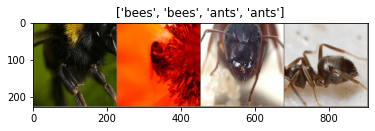

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
data_transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                        data_transform[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(
                       image_datasets[x], batch_size=4, 
                       shuffle=True, num_workers=4)
                                            for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

def imshow(inp, title=None):
  """ Imshow for Tensor """
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
model = models.resnet18(pretrained=True)

# 동결 방식: Model의 parameters들을 해당 코드를 통해 Freeze
for param in model.parameters():
  param.requires_grad = False

print(model)
num_ftrs = model.fc.in_features # 512

# Fully connected layer의 output을 2로 설정
model.fc = nn.Linear(num_ftrs, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001)

epochs = 5

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
t_accs, v_accs, t_loss, v_loss = [], [], [], []

for epoch in range(epochs):
  train_loss = 0
  train_accuracy = 0
  model.train()
  
  # Training pass
  for images, labels in (iter(dataloaders['train'])):
    images = images.cuda()
    labels = labels.cuda() 
    optimizer.zero_grad()

    output = model(images) 
    ps = torch.exp(output) 
    top_p, top_class = ps.topk(1, dim = 1)
    equals = top_class == labels.view(*top_class.shape) 
    train_accuracy += torch.mean(equals.type(torch.FloatTensor))

    loss = criterion(output, labels)
    loss.backward()
    optimizer.step() 
    train_loss += loss.item()

  t_accs.append(train_accuracy/len((iter(dataloaders['train'])))) 
  t_loss.append(train_loss/len((iter(dataloaders['train']))))

  # Validation pass
  test_loss = 0
  test_accuracy = 0
  # Set the model to evaluation mode
  model.eval()

  for images, labels in (iter(dataloaders['val'])):
    images = images.cuda()
    labels = labels.cuda()
    log_ps = model(images)
    test_loss += criterion(log_ps, labels).item()

    ps = torch.exp(log_ps) 
    top_p, top_class = ps.topk(1, dim = 1)
    equals = top_class == labels.view(*top_class.shape) 
    test_accuracy += torch.mean(equals.type(torch.FloatTensor))

  v_accs.append(test_accuracy/len((iter(dataloaders['val'])))) 
  v_loss.append(test_loss/len((iter(dataloaders['val'])))) 

  print("==> Epoch[{}/{}]".format(epoch+1, epochs))
  print("loss: {:.3f}, Accuracy: {:.3f}, val_loss: {:.3f}, val_accuracy: {:.3f}"
  .format(t_loss[-1], t_accs[-1], v_loss[-1], v_accs[-1]))

  model_out_path = './model.pth'
  torch.save(model.state_dict(), model_out_path)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


==> Epoch[1/5]
loss: 0.691, Accuracy: 0.574, val_loss: 0.578, val_accuracy: 0.692
==> Epoch[2/5]
loss: 0.587, Accuracy: 0.664, val_loss: 0.450, val_accuracy: 0.821
==> Epoch[3/5]
loss: 0.531, Accuracy: 0.754, val_loss: 0.387, val_accuracy: 0.878
==> Epoch[4/5]
loss: 0.498, Accuracy: 0.725, val_loss: 0.354, val_accuracy: 0.897
==> Epoch[5/5]
loss: 0.426, Accuracy: 0.824, val_loss: 0.308, val_accuracy: 0.910


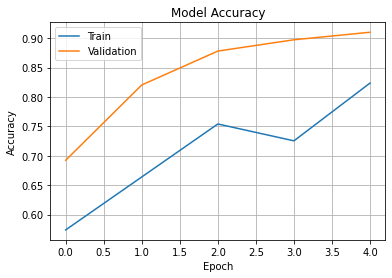

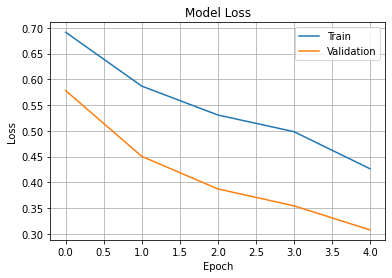

In [ ]:
import matplotlib.pyplot as plt

# 정확률 그래프
plt.title('Model Accuracy')
plt.plot(t_accs, label= "Training Accuracy") 
plt.plot(v_accs, label= "Validation Accuracy") 
plt.ylabel('Accuracy')
plt.xlabel('Epoch') 
plt.legend(['Train','Validation'], loc='best') 
plt.grid()
plt.show()

# 손실 함수 그래프
plt.title('Model Loss')
plt.plot(t_loss, label = "Training loss") 
plt.plot(v_loss, label = "Validation loss") 
plt.ylabel('Loss')
plt.xlabel('Epoch') 
plt.legend(['Train','Validation'], loc='best') 
plt.grid()
plt.show()

## 6. Object Detection 프로그래밍

In [ ]:
!git clone https://github.com/amdegroot/ssd.pytorch/
!wget https://s3.amazonaws.com/amdegroot-models/ssd300_mAP_77.43_v2.pth
!mkdir /root/data
!sh /content/ssd.pytorch/data/scripts/VOC2007.sh /root/data

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
VOCdevkit/VOC2007/JPEGImages/000732.jpg
VOCdevkit/VOC2007/JPEGImages/000734.jpg
VOCdevkit/VOC2007/JPEGImages/000735.jpg
VOCdevkit/VOC2007/JPEGImages/000736.jpg
VOCdevkit/VOC2007/JPEGImages/000737.jpg
VOCdevkit/VOC2007/JPEGImages/000741.jpg
VOCdevkit/VOC2007/JPEGImages/000743.jpg
VOCdevkit/VOC2007/JPEGImages/000744.jpg
VOCdevkit/VOC2007/JPEGImages/000745.jpg
VOCdevkit/VOC2007/JPEGImages/000747.jpg
VOCdevkit/VOC2007/JPEGImages/000749.jpg
VOCdevkit/VOC2007/JPEGImages/000751.jpg
VOCdevkit/VOC2007/JPEGImages/000757.jpg
VOCdevkit/VOC2007/JPEGImages/000758.jpg
VOCdevkit/VOC2007/JPEGImages/000759.jpg
VOCdevkit/VOC2007/JPEGImages/000762.jpg
VOCdevkit/VOC2007/JPEGImages/000765.jpg
VOCdevkit/VOC2007/JPEGImages/000766.jpg
VOCdevkit/VOC2007/JPEGImages/000769.jpg
VOCdevkit/VOC2007/JPEGImages/000773.jpg
VOCdevkit/VOC2007/JPEGImages/000775.jpg
VOCdevkit/VOC2007/JPEGImages/000778.jpg
VOCdevkit/VOC2007/JPEGImages/000779.jpg
VOCdevkit/VOC2007/JPEGImages/000781.jpg
VOCd

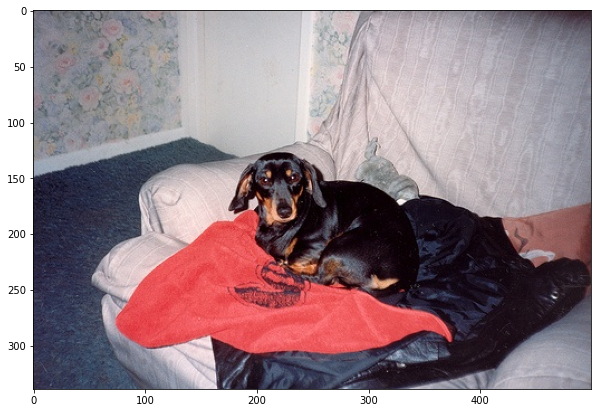

In [ ]:
# ssd.py, detection.py 새로 다운로드 받아서 원래 위치에 설치

import os
import sys
module_path = os.path.abspath(os.path.join('/content/ssd.pytorch'))
if module_path not in sys.path:
  sys.path.append(module_path)

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import numpy as np
import cv2
if torch.cuda.is_available():
  torch.set_default_tensor_type('torch.cuda.FloatTensor')

image = cv2.imread('./data/example.jpg', cv2.IMREAD_COLOR) # uncomment if dataset not downloaded

%matplotlib inline
import matplotlib.pyplot as plt
# data/coco.py의 47번째 줄을 self.label_map = get_label_map(osp.join(osp.join(HOME, '/content/ssd.pytorch/data/'), 'coco_labels.txt'))로 사용해야함
from data import VOC_ROOT, VOCAnnotationTransform, VOCDetection

# here we specify year (07 or 12) and dataset ('test', val, 'train')
testset = VOCDetection(VOC_ROOT, [('2007', 'val')], None, VOCAnnotationTransform())
img_id = 20
image = testset.pull_image(img_id)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# View the sampled input image before transform
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.show()

In [ ]:
x = cv2.resize(image,(300,300)).astype(np.float32)
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
x = x[:, :, ::-1].copy()
x = torch.from_numpy(x).permute(2,0,1)

from ssd import build_ssd
net = build_ssd('test', 300, 21)
net.load_weights('/content/ssd300_mAP_77.43_v2.pth')

xx = Variable(x.unsqueeze(0))
if torch.cuda.is_available():
  xx = xx.cuda()

# ssd.py의 volatile -> requires_grad로 변경
net.eval()
y = net(xx)

Loading weights into state dict...
Finished!


/content/ssd.pytorch/layers/box_utils.py:216: UserWarning: An output with one or more elements was resized since it had shape [3], which does not match the required output shape [2].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  torch.index_select(x1, 0, idx, out=xx1)
/content/ssd.pytorch/layers/box_utils.py:217: UserWarning: An output with one or more elements was resized since it had shape [3], which does not match the required output shape [2].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  torch.index_se

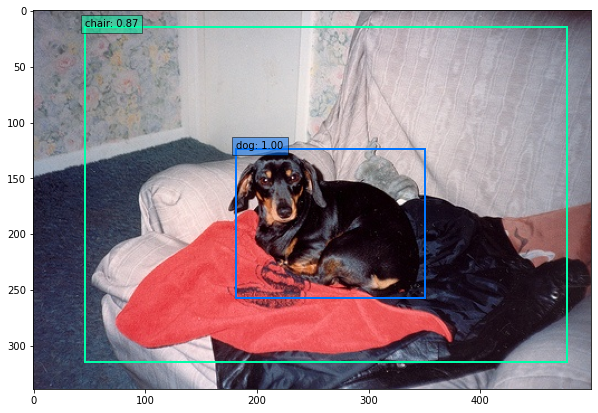

In [ ]:
from data import VOC_CLASSES as labels
top_k = 10

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0,1,21)).tolist()
plt.imshow(rgb_image) # plot the image for matplotlib
currentAxis = plt.gca()

detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(detections.size(1)):
  j = 0
  while detections[0,i,j,0] >= 0.6: # score가 0.6보다 높은 box 그리기
    score = detections[0,i,j,0]
    label_name = labels[i-1]
    display_txt = '%s: %.2f' % (label_name, score)
    pt = (detections[0,i,j,1:]*scale).cpu().numpy()
    coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
    color = colors[i]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
    j+=1